In [1]:
## 기본 라이브러리
import re
import warnings
import numpy as np
import pandas as pd

## 시각화 라이브러리
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

## 머신 러닝 라이브러리
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 기타 라이브러리
from scipy import optimize
from collections import defaultdict

## 설정
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 500)

## Matplotlib 한글 폰트 설정
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('figure', titlesize=70)

%matplotlib inline

In [2]:
def missing_value(df, random_state=42):
    # 장타율, 출루율, 타율, wOBA, wRC 등의 null값은 0으로 처리
    df.loc[df['OBP'].isna(), 'OBP'] = 0
    df.loc[df['SLG'].isna(), 'SLG'] = 0
    df['OPS'] = df['OBP'] + df['SLG']
    df.loc[df['avg'].isna(), 'avg'] = 0
    df['wOBA'] = df['wOBA'].fillna(0)
    df['wRC'] = df['wRC'].fillna(0)

    # PA = 타수(AB) + 볼넷 + 사사구 + 희생번트 + 희생플라이
    df.loc[df['PA'].isna(), 'PA'] = df[['AB', 'BB', 'SB', 'SF', 'SH']].sum(axis=1)

    # IBB, SH, SF : 타석 대비 IBB, SH, SF의 평균값을 타석에 곱해서 구한다.
    df.loc[df['IBB'].isna(), 'IBB'] = round(df.loc[df['IBB'].isna()]['PA'] * 0.002) # 타석 대비 평균값 0.0002
    df.loc[df['SH'].isna(), 'SH'] = round(df.loc[df['SH'].isna()]['PA'] * 0.016) # 타석 대비 평균값 0.016
    df.loc[df['SF'].isna(), 'SF'] = round(df.loc[df['SF'].isna()]['PA'] * 0.007) # 타석 대비 평균값 0.007
    
    # WPA
    df = df.drop('WPA', axis=1)
    
    # WAR
    df = fillna_WAR(df, column='TB', random_state=random_state)
    
    # position: 가장 많이한 포지션
    pos_nulls = list(df.loc[df['position'].isna()]['batter_id'].unique())
    for batter_id in pos_nulls:
        df = fillna_position(df, batter_id)
    return df
        
def fillna_position(df, batter_id):
    null_index = df[(df['batter_id'] == batter_id) & 
                    (df['position'].isna())].index
    index1, index2 = null_index[0], null_index[-1]
    if batter_id == df.iloc[index1 - 1]['batter_id']:
        position = str(df.iloc[index1 - 1]['position'])
    elif batter_id == df.iloc[index2 + 1]['batter_id']:
        position = str(df.iloc[index2 + 1]['position'])
    else: # 가장 많이한 포지션
        position = df[df['batter_id'] == batter_id]['position'].value_counts().keys()[0]
        
    df.loc[(df['batter_id'] == batter_id) & 
           (df['position'].isna()), 'position'] = position
    return df

def fillna_WAR(df, column='TB', random_state=42):
    # train, test, validation split
    df_war = df.copy()
    df_war = df_war.drop(['batter_id', 'batter_name', 'team', 'position', 'career'], axis=1)
    test_war = df_war.loc[df_war['WAR'].isna()]
    train_war = df_war.loc[df_war['WAR'].isna() == False]
    train_war = basic_outlier(train_war, 'WAR')
    X_train_war, X_val_war, y_train_war, y_val_war = train_test_split(train_war.drop(['WAR'], axis=1),
                                                                      train_war['WAR'],
                                                                      test_size=0.2,
                                                                      random_state=random_state)
    
    lr = LinearRegression()
    lr.fit(X_train_war[[column]], y_train_war)
    lr_pred = lr.predict(X_val_war[[column]])
    y_pred = lr.predict(test_war[[column]])
    df.loc[df['WAR'].isna(), 'WAR'] = y_pred
    return df 
    
def basic_outlier(df, column, weight=1.5):
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * weight)
    upper_bound = q3 + (iqr * weight)
    
    return df.loc[(df[column] >= lower_bound) &
                   (df[column] <= upper_bound)].reset_index(drop=True)

def mahalanobis_dist_outlier(df, targets, plot=True, verbose=False, q=0.95):
    from scipy.stats import chi2
    
    # Import dataset and clean it
    df_target = df[targets]
    df_target = df_target.fillna(0)
    df_target = df_target.to_numpy()

    # 1. Covariance matrix
    covariance  = np.cov(df_target , rowvar=False)

    # 2. Covariance matrix power of -1
    covariance_pm1 = np.linalg.matrix_power(covariance, -1)

    # 3. Center point
    centerpoint = np.mean(df_target , axis=0)

    # 4. Distances between center point and 
    distances = []
    for i, val in enumerate(df_target):
        p1 = val
        p2 = centerpoint
        distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
        distances.append(distance)
    distances = np.array(distances)

    # 5. Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
    cutoff = chi2.ppf(q, df_target.shape[1])

    # 6. Index of outliers
    outlier_indices = np.where(distances > cutoff )[0]

    if verbose:
        print('--- Index of Outliers ----')
        print(outlier_indices)

        print('--- Observations found as outlier -----')
        print(df_target[ distances > cutoff , :])

    if plot:
        ## 7. Finding ellipse dimensions 
        pearson = covariance[0, 1]/np.sqrt(covariance[0, 0] * covariance[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        lambda_, v = np.linalg.eig(covariance)
        lambda_ = np.sqrt(lambda_)

        # Ellipse patch
        ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                          width=lambda_[0]*np.sqrt(cutoff)*2, height=lambda_[1]*np.sqrt(cutoff)*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#fab1a0')
        ellipse.set_facecolor('#0984e3')
        ellipse.set_alpha(0.5)
        fig = plt.figure()
        ax = plt.subplot()
        ax.add_artist(ellipse)
        plt.scatter(df_target[: , 0], df_target[ : , 1])
        plt.xlabel(targets[0])
        plt.ylabel(targets[1])
        plt.show()
    
    return df.loc[df.index.isin(outlier_indices) == False], outlier_indices

def sabermetrics(df):
    df['1B'] = df['H'] - (df['2B'] + df['3B'] + df['HR']) # 1루타
    df['XBH'] = df['HR'] + df['2B'] + df['3B'] # 장타
    df['BOB'] = df['H'] + df['BB'] + df['HBP'] # 출루
    
    # BABIP
    df['BABIP'] = (df['H'] - df['HR']) / (df['AB'] - df['SO'] - df['HR'] + df['SF'])
    df['BABIP'] = df['BABIP'].fillna(0)
    
    # GPA
    df['GPA'] = (1.57 * df['OBP']) + df['SLG'] / 4
    
    # RC
    df['OBF'] = df['H'] + df['BB'] - df['CS'] + df['HBP'] - df['GDP'] # 출루 능력
    df['AF'] = (0.24 * (df['BB'] - df['IBB'] + df['HBP']) 
                + 0.62 * df['SB'] + 0.5 * (df['SH'] + df['SF']) - 0.03 * df['SO']) # 진루 능력
    df['OF'] = df['AB'] + df['BB'] + df['HBP'] + df['SH'] + df['SF'] # 기회 창출
    df['RC'] = ((2.4 * df['OF'] + df['OBF']) * (3 * df['OF'] + df['AF']) / 9 * df['OF']) - 0.9 * df['OF']
    df['RC27'] = df['RC'] / 27
    
    # XR
    ## 개인 기대득점
    df['XR'] = (
        0.5 * df['1B'] + 0.72 * df['2B'] + 1.04 * df['3B'] + 1.44 * df['HR'] + 0.34 * (df['HBP'] + df['BB'] - df['IBB'])
        + 0.25 * df['IBB'] + 0.18 * df['SB'] - 0.32 * df['CS'] - 0.09 * (df['AB'] - df['H'] - df['SO']) - 0.098 * df['SO']
        - 0.37 * df['GDP'] + 0.37 * df['SF'] + 0.04 * df['SH']
    ) 
    ## 팀 기대득점
    df_team = df.copy().groupby(['year', 'team']).sum().reset_index()[['year', 'team', 'XR']]
    df_team = df_team.rename(columns={'XR':'teamXR'})
    df = pd.merge(df, df_team, on=['year', 'team'], how='left')
    
    # 팀 기대득점 대비 XR
    df['tXR'] = (df['XR'] / df['teamXR']) * 100
    return df

def OPS_plus(df):
    years = sorted(df.year.unique())
    for year in years:
        tmp = df.loc[df['year'] == year]
        obp_mean = tmp['OBP'].mean()
        slg_mean = tmp['SLG'].mean()
        df.loc[df['year'] == year, 'OPS+'] = 100 * ((tmp['OBP'] / obp_mean) + (tmp['SLG'] / slg_mean) - 1)        
    return df

In [3]:
def preprocess(df, 
               outlier_targets=['AB', 'OPS+'], q=0.95, 
               lower_season=2001, upper_season=9999,
               drop_columns=['batter_name', 'career'],
               random_state=42, last_season=2018,
               Train=True):
    ## 1. Missing value
    df = missing_value(df, random_state=random_state)
    
    ## 2. outlier
    if Train:
        df = df.loc[(df['year'] >= lower_season) &
                    (df['year'] <= upper_season)].reset_index(drop=True)
        if 'OPS+' in outlier_targets:
            df = OPS_plus(df)
        df, _ = mahalanobis_dist_outlier(df, targets=outlier_targets, plot=False, q=q) # mahalnobis distance outlier
    df = OPS_plus(df)
    
    ## 3. new variables
    ### 3.1 sabermetrics
    df = sabermetrics(df)
    pa_columns = ['R', 'H', '2B', '3B', 'HR', 'TB', 'RBI', 'SB', 'CS', 
                  'BB', 'HBP', 'SO', 'GDP', '1B', 'XBH', 'BOB', 'OBF']
    # 타석수 대비 기록
    for col in pa_columns:
        df[col + '/PA'] = (df[col] / (df['PA'] + 1)).fillna(0)
        
    # 3.2 categorical
    # team
    df.loc[df.team.isin(['우리', '현대', '넥센', '키움']), 'team'] = '히어로즈'
    df.loc[df.team.isin(['OB']), 'team'] = '두산'
    df.loc[df.team.isin(['해태']), 'team'] = 'KIA'
    df.loc[df.team.isin(['쌍방울']), 'team'] = 'SK'
    df_team = pd.get_dummies(df['team'])
    df = pd.concat([df, df_team], axis=1)
    
    # position
    df['position'] = [x if x == 'DH' or x == 'C' else 'F'
                     for x in df['position']]
    df_pos = pd.get_dummies(df['position'])
    df = pd.concat([df, df_pos], axis=1)
    drop_columns += ['team', 'position']
    
    if Train:
        correct_columns = list(df.select_dtypes(['int', 'float']).columns)
        del_columns = ['batter_id', 'year', 'OPS', 'age', 'AB']
        for x in del_columns:
            correct_columns.remove(x)

        for year in sorted(df.year.unique()):
            avg_year = df.loc[df['year'] == year][correct_columns].mean()
            df.loc[df['year'] == year, correct_columns] = df[correct_columns] / avg_year
    
    df = df.drop(drop_columns, axis=1)
    return df
    
def create_target_value(df, column, target_name='target'):
    # 다음 시즌
    target = list(df[column])
    next_AB = list(df['AB'])
    del target[0] 
    del next_AB[0]
    target.append(-1)
    next_AB.append(-1)
    df[target_name] = target
    df['nextAB'] = next_AB
    
    # 타자 이름별 연도가 가장 큰 열의 OPS값을 -1로 바꿔준다.
    # 현역일 경우 2018년, 은퇴한 선수일 경우 은퇴년도가 -1이 된다.
    batter_year = df.groupby('batter_id')['year'].max().reset_index()
    for batter_id, year in zip(list(batter_year['batter_id']), list(batter_year['year'])):
        df.loc[(df['batter_id'] == batter_id) & (df['year'] == year), [target_name, 'nextAB']] = -1
    return df



def aging_curve(func, df, target='WAR', lower=0.1, upper=0.9, plot=True,
                median=False, ma=False, window=3, opt_return=False,
                age_upper=99, data=True, curve_fit=True):
    
    df = df.loc[(df[target] > df[target].quantile(lower)) &
                (df[target] < df[target].quantile(upper)) &
                (df['age'] < age_upper)]
    if median:
        df_age = df.groupby('age').median().reset_index()
    else:
        df_age = df.groupby('age').mean().reset_index()
    
    if ma:
        title = 'Aging Curve MA(' + target + ')'
        xdata = df_age['age'].rolling(window=window).mean().dropna()
        ydata = df_age[target].rolling(window=window).mean().dropna()
    else:
        title = 'Aging Curve (' + target + ')' 
        xdata = df_age['age']
        ydata = df_age[target]
        
    popt, pcov = optimize.curve_fit(func, xdata, ydata)
    
    if plot:
        plt.figure(figsize=(10, 6))
        if data:
            plt.plot(xdata, ydata, '-o', label='avg. '+ target, color='tab:blue')
        if curve_fit:
            plt.plot(xdata, func(xdata, *popt), '-o', label=title, color='tab:orange')
        plt.xticks(ticks=xdata)
        plt.legend()
        plt.xlabel('Age')
        plt.ylabel(target)
        plt.title(title)
        plt.show();

    if opt_return:
        y_hat = func(xdata, *popt)
        return {x:y for x, y in zip(xdata, y_hat)}

def func(x, a, b, c, d, e):
    return a * x ** 5 + b * x ** 4 + c * x ** 3 + d * x + e

In [4]:
rsb = pd.read_csv('./data/Regular_Season_Batter.csv') # 정규시즌 + 스탯티즈 크롤링 데이터
df = rsb.copy()
df = preprocess(df, drop_columns=['batter_name', 'career'], q=0.95)

# Agin Curve
popt = aging_curve(func=func, df=df, target='OPS', data=False, opt_return=True, plot=False)
df['age'] = [popt[a] if a != 42 else popt[18] for a in df['age']]

# Create target value
df = create_target_value(df, column='OPS')

In [5]:
# OPS, age 시즌별 평균으로 나누어 보정 
correct_columns = ['OPS', 'age', 'AB']
for year in sorted(df.year.unique()):
    mean = df.loc[df['year'] == year][correct_columns].mean()
    df.loc[df['year'] == year, correct_columns] = df[correct_columns] / mean

In [ ]:
def get_kbo_best_features(model, df, n_features=35, test_size=0.2):
    X = df.drop(['batter_id', 'target'], axis=1)
    y = df['target']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    best_features = list(rfe.get_feature_names_out())
    print("Best Features: \n", best_features)
    return best_features

In [6]:
train = df.loc[df['target'] != -1]
lgb = LGBMRegressor(n_estimators=50, max_depth=3, n_jobs=-1)

best_features = get_kbo_best_features(lgb, train, n_features=35)
if 'nextAB' not in best_features:
    best_features += ['nextAB']
train = train[['batter_id', 'target'] + best_features]

Best Features: 
 ['year', 'age', 'G', 'E', 'HR', 'TB', 'RBI', 'BB', 'HBP', 'SH', 'SLG', 'OPS', 'wOBA', 'wRC', 'WAR', 'OBF', 'AF', 'XR', 'teamXR', 'R/PA', 'H/PA', '2B/PA', '3B/PA', 'HR/PA', 'RBI/PA', 'CS/PA', 'BB/PA', 'HBP/PA', 'SO/PA', 'GDP/PA', '1B/PA', 'XBH/PA', 'BOB/PA', '두산', 'nextAB']


In [ ]:
def train_kbo_ops_model(model, df, target, drop_columns = ['batter_id', 'target', 'nextAB'], verbose=True):
    
    score_dict = defaultdict(list)
    seasons = sorted(df['year'].unique())
    if verbose:
        print("Input -> Predict")
    print("-" * 45)
    for season in seasons:
        # train, validation split
        train = df[df['year'] != season]
        validation = df[df['year'] == season]
        AB = validation['nextAB']
        X_train, y_train = train.drop(drop_columns, axis=1), train[target]
        X_val, y_val = validation.drop(drop_columns, axis=1), validation[target]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        wrmse = weighted_root_mean_squred_error(y_val, y_pred, AB)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        score_dict['wrmse'].append(wrmse)
        score_dict['rmse'].append(rmse)
        if verbose:
            print(f"{int(season)} -> {int(season + 1)}: WRMSE = {wrmse:.4f} | RMSE = {rmse:.4f}")
    if verbose:
        print("-" * 45)
    print(f"WRMSE avg: {np.mean(score_dict['wrmse']):.4f} | RMSE avg.: {np.mean(score_dict['rmse']):.4f}")
    return model, score_dict    

def weighted_root_mean_squred_error(y_true, y_pred, AB):
    return np.sqrt(np.sum(((y_true - y_pred) ** 2) * AB) / np.sum(AB))

In [7]:
lr = LinearRegression()
rdg = Ridge()
svm = SVR()
rf = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1)
xg = XGBRegressor(n_estimators=50, max_depth=3, n_jobs=-1)
lgb = LGBMRegressor(n_estimators=50, max_depth=3, n_jobs=-1)

In [8]:
lr_model, lr_score = train_kbo_ops_model(model=lr, df=train, target='target', verbose=False)
rdg_model, rdg_score = train_kbo_ops_model(model=rdg, df=train, target='target', verbose=False)
svm_model, svm_score = train_kbo_ops_model(model=svm, df=train, target='target', verbose=False)
rf_model, rf_score = train_kbo_ops_model(model=rf, df=train, target='target', verbose=False)
xg_model, xg_score = train_kbo_ops_model(model=xg, df=train, target='target', verbose=False)
lgb_model, lgb_score = train_kbo_ops_model(model=lgb, df=train, target='target', verbose=False)

---------------------------------------------
WRMSE avg: 0.1104 | RMSE avg.: 0.1399
---------------------------------------------
WRMSE avg: 0.1106 | RMSE avg.: 0.1396
---------------------------------------------
WRMSE avg: 0.1404 | RMSE avg.: 0.1700
---------------------------------------------
WRMSE avg: 0.1114 | RMSE avg.: 0.1412
---------------------------------------------
WRMSE avg: 0.1157 | RMSE avg.: 0.1457
---------------------------------------------
WRMSE avg: 0.1116 | RMSE avg.: 0.1406


In [9]:
estimators = [('lr', lr), ('rdg', rdg), ('rf', rf), ('xg', xg), ('lgb', lgb)]
stk = StackingRegressor(estimators=estimators)
stk_model, stk_score = train_kbo_ops_model(model=stk, df=train, target='target', verbose=True)

Input -> Predict
---------------------------------------------
2001 -> 2002: WRMSE = 0.1031 | RMSE = 0.1063
2002 -> 2003: WRMSE = 0.1330 | RMSE = 0.1311
2003 -> 2004: WRMSE = 0.0937 | RMSE = 0.1461
2004 -> 2005: WRMSE = 0.0978 | RMSE = 0.1510
2005 -> 2006: WRMSE = 0.1061 | RMSE = 0.1227
2006 -> 2007: WRMSE = 0.0979 | RMSE = 0.1276
2007 -> 2008: WRMSE = 0.1079 | RMSE = 0.1397
2008 -> 2009: WRMSE = 0.1216 | RMSE = 0.1384
2009 -> 2010: WRMSE = 0.1203 | RMSE = 0.1269
2010 -> 2011: WRMSE = 0.0963 | RMSE = 0.1310
2011 -> 2012: WRMSE = 0.1053 | RMSE = 0.1588
2012 -> 2013: WRMSE = 0.1088 | RMSE = 0.1579
2013 -> 2014: WRMSE = 0.1188 | RMSE = 0.1576
2014 -> 2015: WRMSE = 0.1203 | RMSE = 0.1320
2015 -> 2016: WRMSE = 0.1172 | RMSE = 0.1502
2016 -> 2017: WRMSE = 0.1147 | RMSE = 0.1445
2017 -> 2018: WRMSE = 0.1029 | RMSE = 0.1420
---------------------------------------------
WRMSE avg: 0.1097 | RMSE avg.: 0.1390


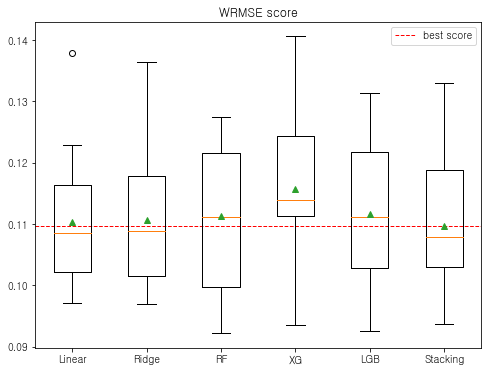

In [10]:
names = ['Linear', 'Ridge', 'RF', 'XG', 'LGB', 'Stacking']
results = [lr_score['wrmse'], rdg_score['wrmse'], rf_score['wrmse'], 
           xg_score['wrmse'], lgb_score['wrmse'], stk_score['wrmse']]

plt.figure(figsize=(8, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.hlines(xmin=0.5, xmax=6.5, y=np.mean(stk_score['wrmse']), colors='r', 
           linestyles='--', linewidths=1, label='best score')
plt.legend()
plt.title('WRMSE score')
plt.show();

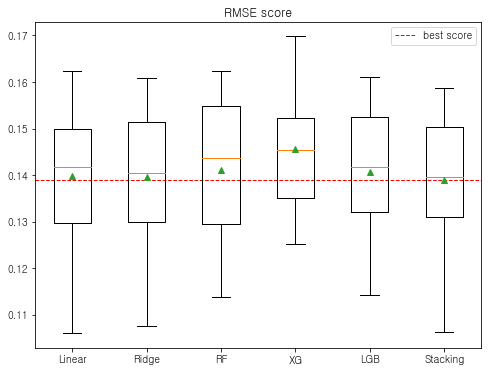

In [11]:
names = ['Linear', 'Ridge', 'RF', 'XG', 'LGB', 'Stacking']
results = [lr_score['rmse'], rdg_score['rmse'], rf_score['rmse'], 
           xg_score['rmse'], lgb_score['rmse'], stk_score['rmse']]

plt.figure(figsize=(8, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.hlines(xmin=0.5, xmax=6.5, y=np.mean(stk_score['rmse']), colors='r', 
           linestyles='--', linewidths=1, label='best score')
plt.legend()
plt.title('RMSE score')
plt.show();

In [12]:
def preprocess_test(df_origin, aging_curve, best_features, input_season=2018):
    test = preprocess(df_origin, Train=False)
    rm_outlier, _ = mahalanobis_dist_outlier(test, targets=['AB', 'OPS+'], plot=False)
    rm_outlier = rm_outlier.loc[rm_outlier['year'] == input_season]
    test = test.loc[test['year'] == input_season]

    correct_columns = list(test.select_dtypes(['int', 'float']).columns)
    del_columns = ['batter_id', 'year', 'OPS', 'age']
    for x in del_columns:
        correct_columns.remove(x)

    for year in sorted(test.year.unique()):
        avg_year = rm_outlier.loc[rm_outlier['year'] == year][correct_columns].mean() # 이상치 제거한 평균
        test.loc[test['year'] == year, correct_columns] = test[correct_columns] / avg_year

    # Aging Curve
    test['age'] = [aging_curve[a] if a != 42 else aging_curve[18] for a in test['age']]

    # OPS, age 시즌별 평균으로 나누어 보정 
    correct_columns = ['OPS', 'age']
    for year in sorted(test.year.unique()):
        mean = rm_outlier.loc[rm_outlier['year'] == year][correct_columns].mean() # 이상치 제거한 평균
        test.loc[test['year'] == year, correct_columns] = test[correct_columns] / mean
        
    if 'nextAB' in best_features:
        best_features.remove('nextAB')

    return test[['batter_id'] + best_features]

In [13]:
submission = pd.read_csv('./submission/submission.csv')
y_test = preprocess_test(df_origin=rsb, aging_curve=popt, best_features=best_features, input_season=2018)

In [14]:
def predict_kbo_ops_model(model, y_test, submission, drop_columns=['batter_id']):
    y_test = y_test.sort_values('batter_id').reset_index(drop=True)
    batter_id = y_test['batter_id']
    y_test = y_test.drop(drop_columns, axis=1)
    y_pred = pd.DataFrame(model.predict(y_test), columns=['batter_ops'])
    y_pred = pd.concat([batter_id, y_pred], axis=1)
    submission = pd.merge(submission[['batter_id', 'batter_name']], y_pred, on='batter_id', how='left')
    return submission

In [15]:
y_submission = predict_kbo_ops_model(stk_model, y_test, submission)
# y_submission.to_csv('./submission/stk_submission.csv', index=False)